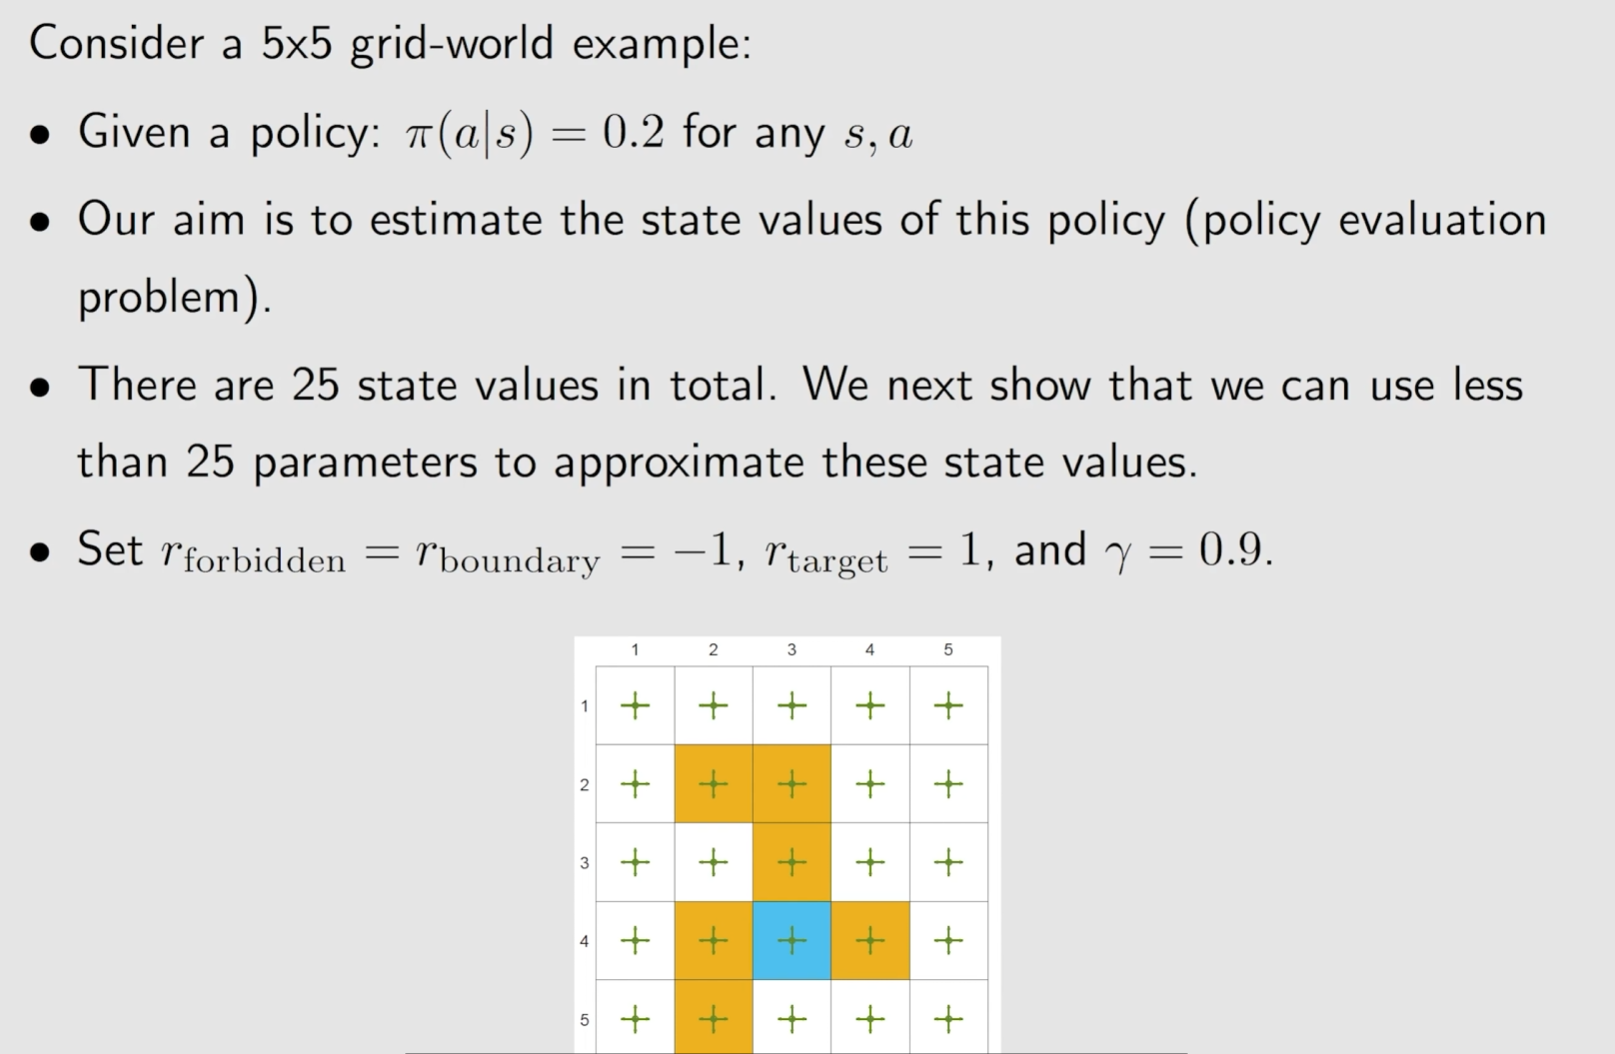


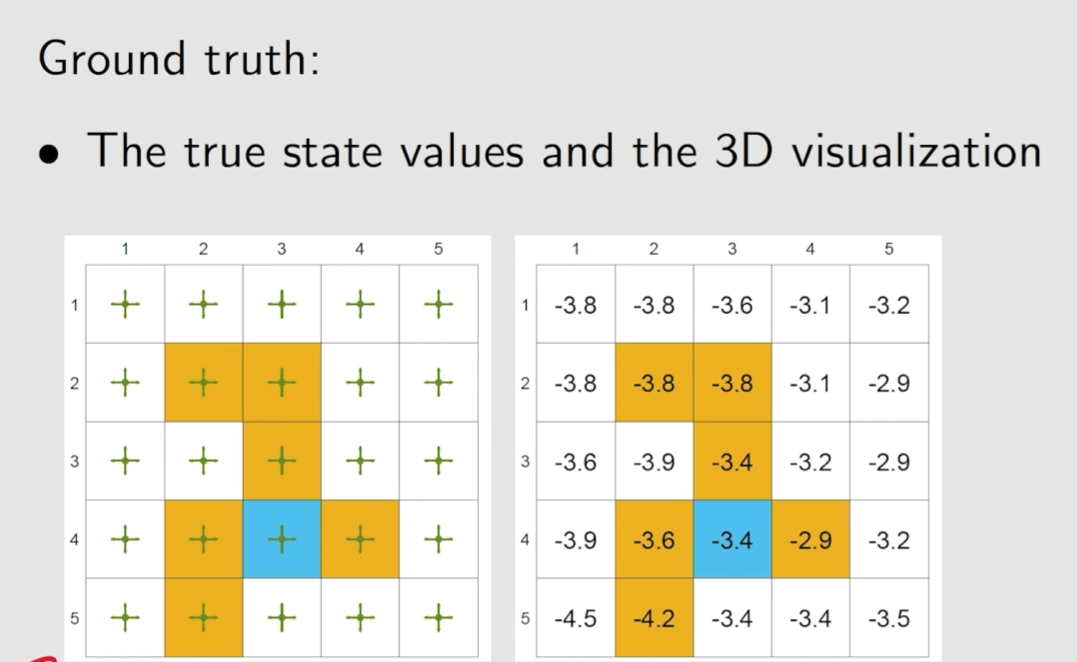

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from generate_episode import gen_multi_episodes, gen_episode
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [162]:
ground_truth = np.array([[-3.8, -3.8, -3.6, -3.1, -3.2],
                         [-3.8, -3.8, -3.8, -3.1, -2.9],
                         [-3.6, -3.9, -3.4, -3.2, -2.9],
                         [-3.9, -3.6, -3.4, -2.9, -3.2],
                         [-4.5, -4.2, -3.4, -3.4, -3.5]])
n_actions = 5
grid_edge_length = 5
n_states = ground_truth.size    
forbidden_states = [7 ,8, 13, 17, 19, 22] 
tgt_state = 18    
# pi's shape: (25, 5)
pi = np.zeros(shape=(n_states, n_actions)) + 0.2
r_forbid = -10
r_bound = -10
r_normal = 0
r_tgt = 1
gamma = 0.9



class TargetNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.sxa = torch.tensor([[(i // 5) + 1, i % 5] for i in range(n_states * n_actions)],dtype=torch.float)
        self.seq = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        out = self.seq(x)
        return out
    
class MainNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.sxa = torch.tensor([[(i // 5) + 1, i % 5] for i in range(n_states * n_actions)],dtype=torch.float)
        self.seq = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        out = self.seq(x)
        return out
    
tgt_model = TargetNet()
out = tgt_model(tgt_model.sxa)    
all_state_max_q = np.asarray([max(out[i*5:i*5+5]).item() for i in range(n_states)])
all_state_max_q, all_state_max_q.shape

(array([-0.25099194, -0.33490768, -0.4079102 , -0.49026701, -0.56933886,
        -0.63270235, -0.70708978, -0.77473038, -0.83784765, -0.91259217,
        -0.98367703, -1.04679441, -1.11937773, -1.19036674, -1.25574064,
        -1.33169138, -1.41475844, -1.49782503, -1.58089137, -1.66395807,
        -1.74702454, -1.83009112, -1.91315806, -1.99622464, -2.07929158]),
 (25,))

In [65]:
def get_num(item):
    return int(item.split("_")[-1])

def trans_state2ij(item, grid_edge_length):
    """
    把状态一维索引转换为二维索引, i,j = (0~24)
    """
    state = get_num(item)
    mod = state % grid_edge_length
    j = mod if mod != 0 else 5
    i = int(((state - j) / grid_edge_length) + 1)
    return (i-1, j-1)


def visual_3d(data, z_min=-5, z_max=-2):
    # 假设 pred 已经有数据
    # pred = np.random.rand(5, 5)  # 示例数据替代你的 pred 数组

    # 生成坐标网格（假设是 5x5 的二维数组）
    
    
    x = np.arange(0, 5)
    y = np.arange(0, 5)
    X, Y = np.meshgrid(x, y)  # 生成网格坐标
    Z = data  # 你的二维数组

    # 创建三维画布
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制表面图
    surf = ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='k', linewidth=0.5)

    # 固定z轴取值范围
    ax.set_zlim(z_min, z_max)

    # 添加颜色条和标签
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_xlabel('row')
    ax.set_ylabel('column')
    ax.set_zlabel('Value')
    ax.set_title('3D Surface Plot')

    # 启用交互模式，允许图表旋转
    plt.ion()

    # 显示图形
    plt.show()

    # 保持图表直到关闭窗口
    plt.ioff()
    
def visual_error(x, y, alpha=None):
    # %matplotlib inline
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
    ax.plot(x, y, label=f"TD-Linear:α={alpha}")
    ax.set_xlabel("Episode Index")
    ax.set_ylabel("State Value error(RMSE)")
    ax.legend()
    plt.show()

def visual_return(x, y, alpha=None):
    %matplotlib inline
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
    ax.plot(x, y, label=f"Sarsa:α={alpha}")
    ax.set_xlabel("Episode Index")
    ax.set_ylabel("Return")
    ax.legend()
    plt.show()


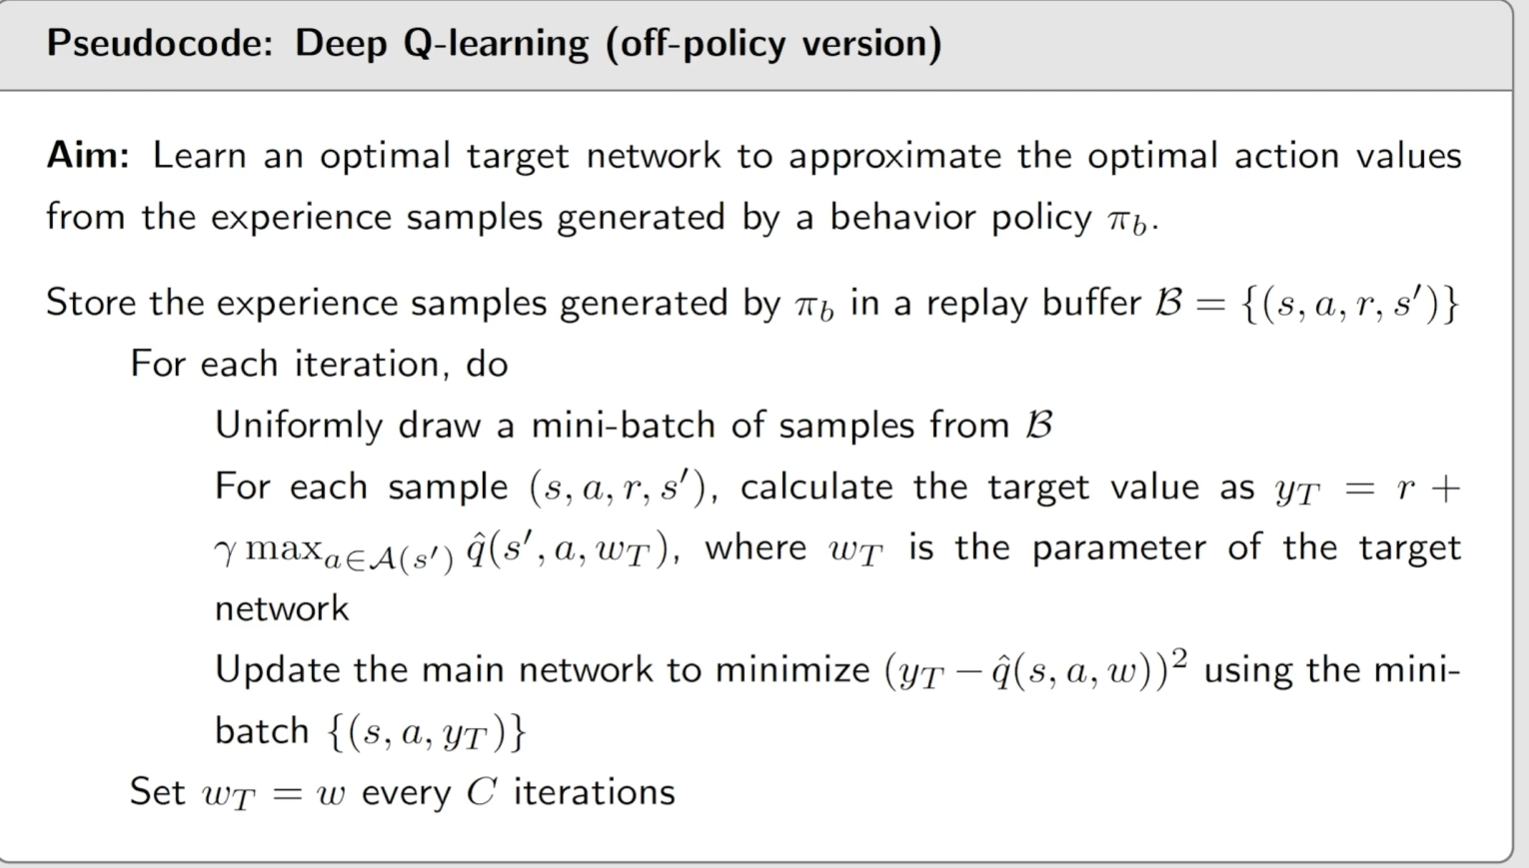
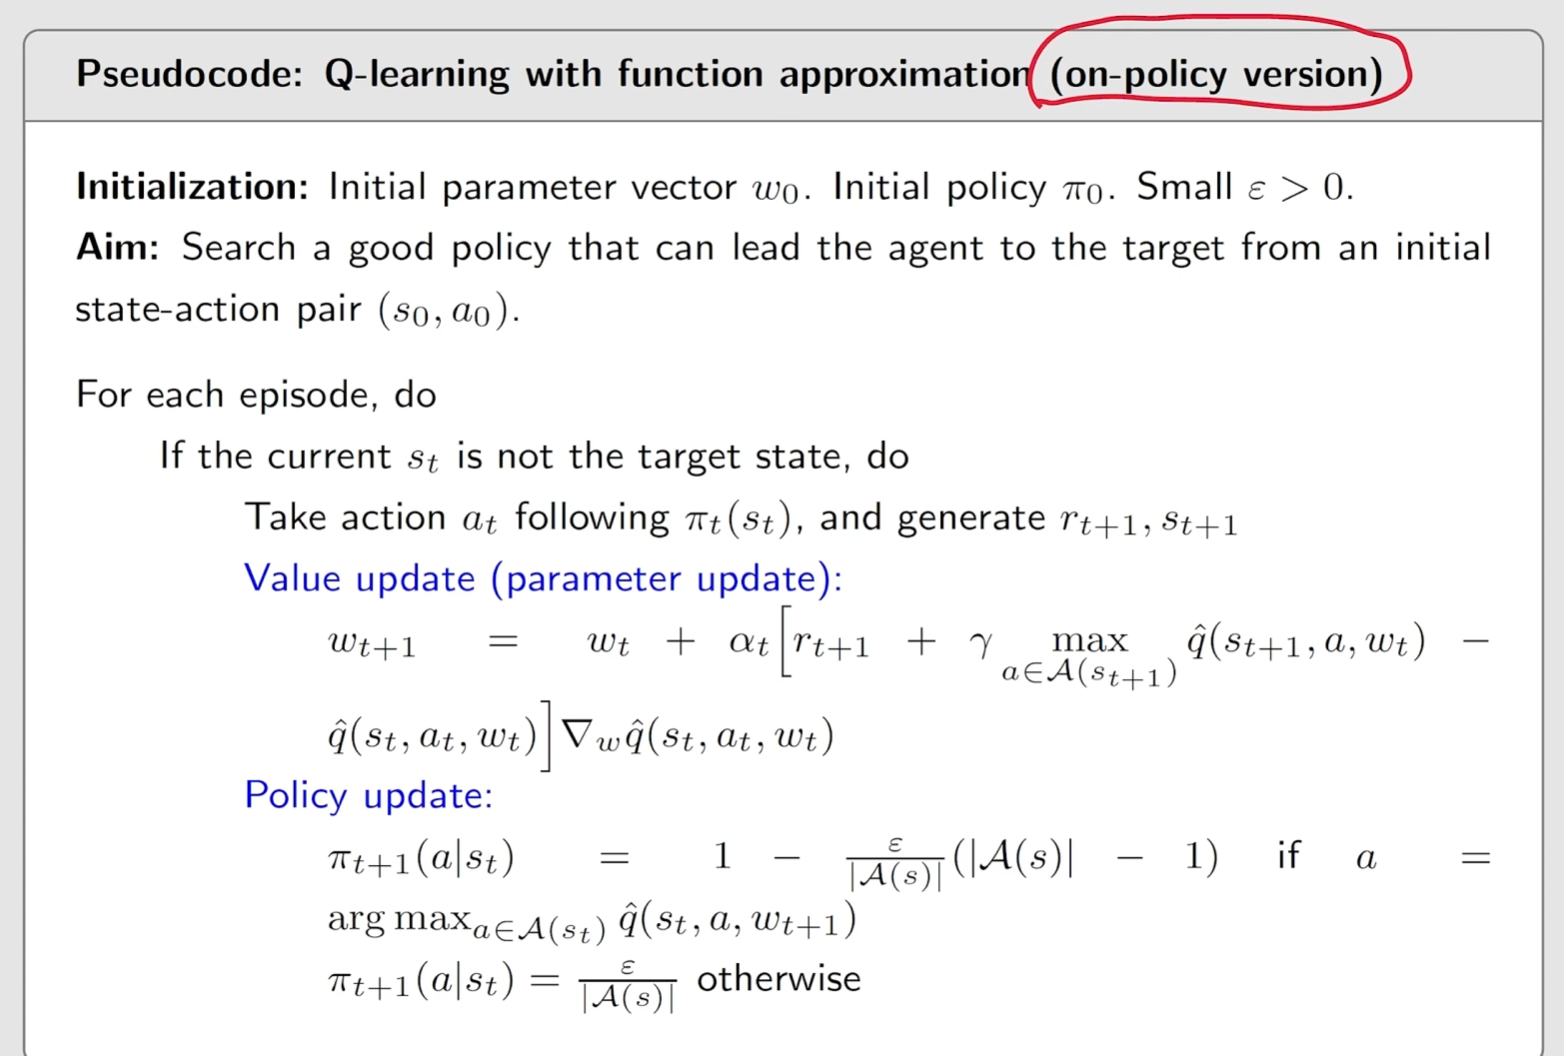
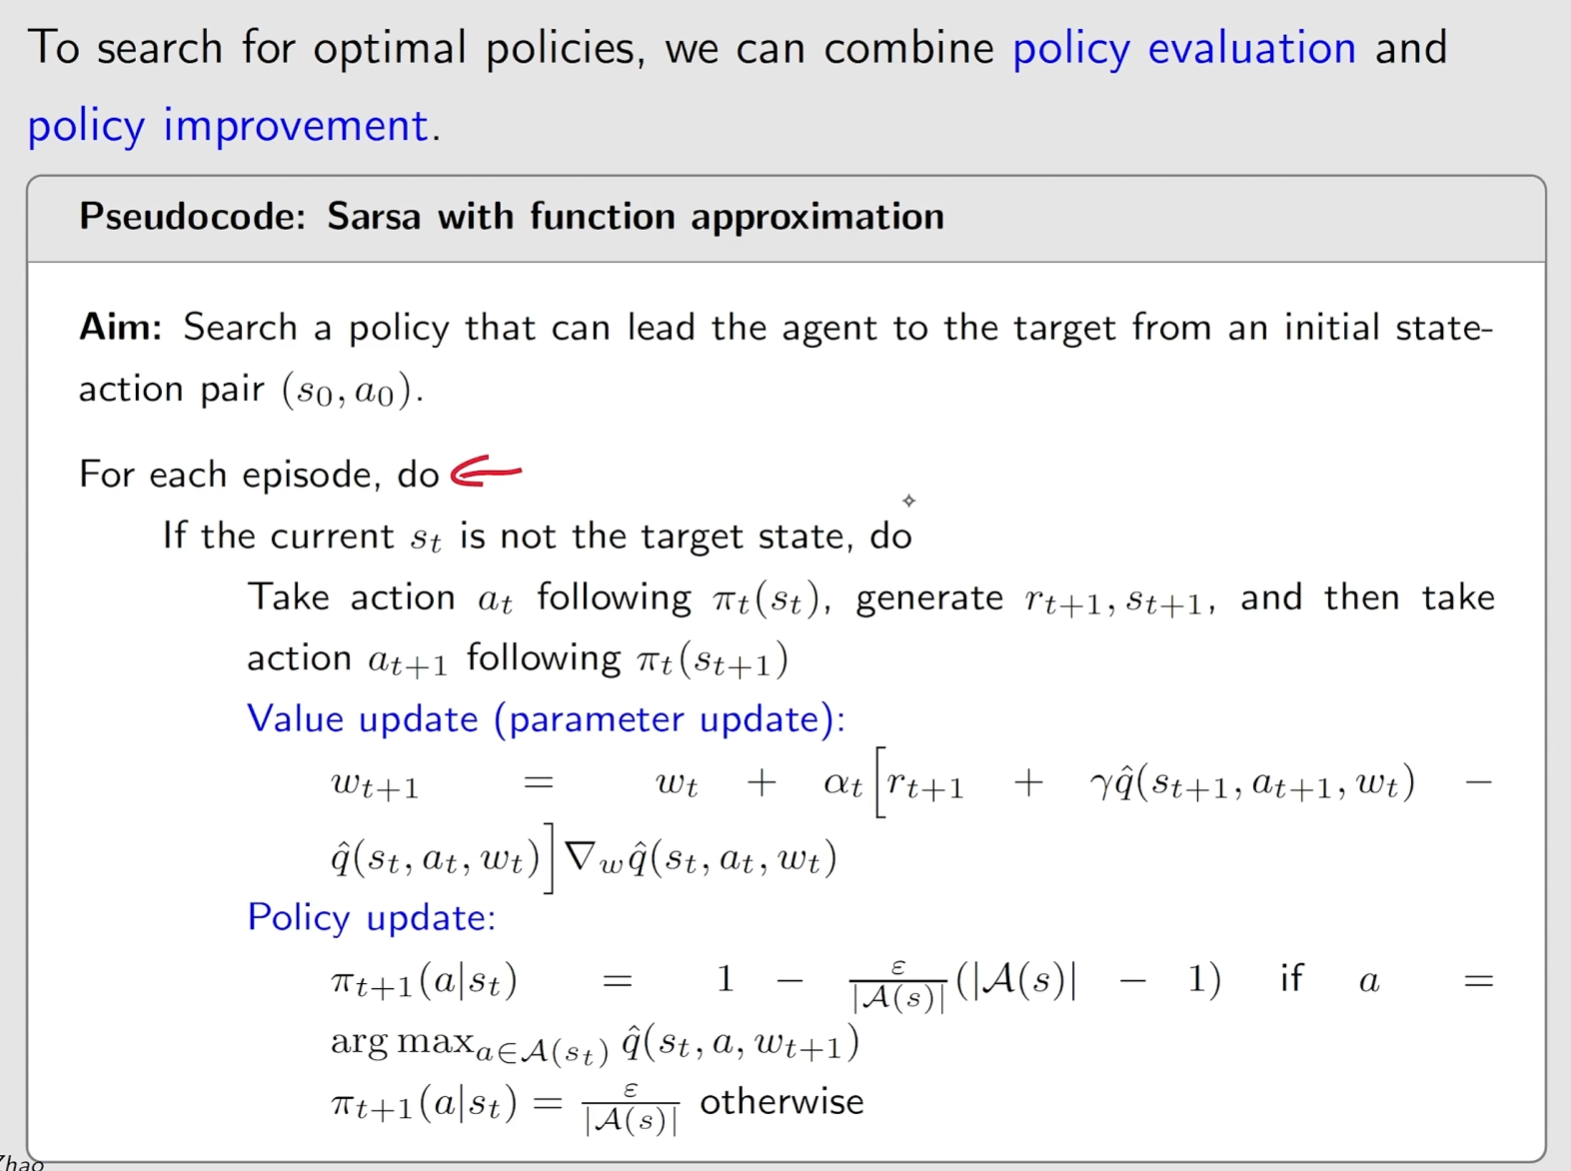

  0%|          | 0/125 [00:00<?, ?it/s]

epoch: 20/20, train loss: 21.4402: 100%|██████████| 125/125 [00:00<00:00, 472.79it/s, **Target Model Updated! Update Count: 250**]


[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
122


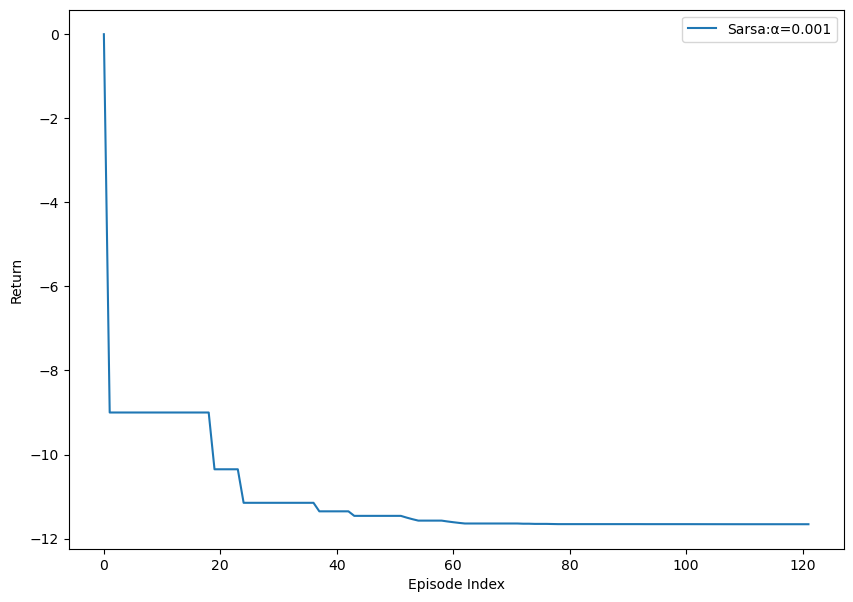

In [207]:
# eps-(0,1) eps越大，概率越均匀。0为greedy, 1为uniform
eps = 0.3
phi_order = 20
w = np.random.normal(size=(phi_order, 1))
alpha = 1e-3
error_ls = []
pi_b = np.zeros(shape=(n_states, n_actions)) + 0.2
tgt_model_update_iter = 10

tgt_model = TargetNet()
out = tgt_model(tgt_model.sxa)    
all_state_max_q = np.asarray([max(out[i*5:i*5+5]).item() for i in range(n_states)])
main_model = MainNet()
main_model.load_state_dict(tgt_model.state_dict())

episode = []
G_ls = []

experience_samples = gen_episode(pi=pi_b, episode_length=500, grid_edge_length=grid_edge_length, forbidden_state=forbidden_states, 
                tgt_state=tgt_state, r_normal=r_normal, r_bound=r_bound, r_forbid=r_forbid, r_tgt=r_tgt, 
                mode="sars", init_pos=(0,0))
    
# 获取yT作为label和s_a_pair
yT = []
s_a_pair = []
for i, trajectory in enumerate(experience_samples):
    # 状态索引为一维, 值域(1~25)
    s_t = get_num(trajectory[0])
    a_t = get_num(trajectory[1])
    r_next_t = get_num(trajectory[2])
    s_next_t = get_num(trajectory[3])

    yT.append(r_next_t + gamma * all_state_max_q[s_next_t-1])
    s_a_pair.append([s_t, a_t])
yT = torch.tensor(yT, dtype=torch.float)
s_a_pair = torch.tensor(s_a_pair, dtype=torch.float)


epoch = 20
lr = 1e-3
batch_szie = 4
device = "cuda"

# 组装数据
train_ds = list(zip(s_a_pair, yT))
train_dl = DataLoader(train_ds, batch_size=batch_szie, shuffle=True)

# train 
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(main_model.parameters(), lr=lr)

tgt_model = tgt_model.to(device)
main_model = main_model.to(device)
cnt_iter = 0
cnt_update = 0
for e in range(epoch):
    bar = tqdm(train_dl)
    for x, y in bar:
        cnt_iter += 1
        x, y = x.to(device), y.to(device)
        q_hat = main_model(x)
        loss = criterion(q_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        bar.set_description(f"epoch: {e+1}/{epoch}, train loss: {loss.item():.4f}")
        if cnt_iter % tgt_model_update_iter == 0:
            cnt_update += 1
            main_model.load_state_dict(tgt_model.state_dict())
            bar.set_postfix_str(f"**Target Model Updated! Update Count: {cnt_update}**")
            
main_out = main_model.cpu()(main_model.sxa)    
main_out_max_q = np.asarray([(max(main_out[i*5:i*5+5]).item(), main_out[i*5:i*5+5].argmax()) for i in range(n_states)])
pi = np.zeros(shape=(n_states, n_actions))
for i in range(n_states):
    pi[i, :] = eps / n_actions
    pi[i, int(main_out_max_q[i, 1])] = 1 - (eps/n_actions) * (n_actions - 1)

# calculte return
pi_episode = gen_episode(pi=pi, episode_length=1, grid_edge_length=grid_edge_length, forbidden_state=forbidden_states, 
                        tgt_state=tgt_state, r_normal=r_normal, r_bound=r_bound, r_forbid=r_forbid, r_tgt=r_tgt, mode="sarsa", init_pos=(0,0), end_pos=(3,2))
G = 0
for j, pi_trajectory in enumerate(pi_episode):
    reward = get_num(pi_trajectory[2])
    G += gamma ** j * reward
    G_ls.append(G)
    
print(pi.argmax(1))
print(len(pi_episode))
visual_return(range(len(G_ls)), G_ls, alpha=alpha)